# Inequality, Data Visualization and Database rants

In my usual dopamine visual injection through Reddit, I came across with a Latinometrics plot showing the top 1% share of pre-tax income in the world, with a focus on Latin America. Its corresponding [article](https://latinometrics.substack.com/p/inequality-youtube-views-and-mercado?utm_source=%2Fsearch%2Finequality&utm_medium=reader2) provides and interesting glance of the inequality, but I was quite curious on what do the other countries look like. Also, I noticed that the shape of the plot can be improved by using a box-plot and, for fun, make it interactive. So, I went to the source, the [World Inequality Database](https://wid.world) to reproduce the plot and add my own insights. In an ideal world, retrieving data from a database it would be straight forward. However, it rapidly downspired to not so straighforward data extraction and had to made several transformations in order to be able to work with data.

The contents are organized as follows: First, I present the WID and my opinion on their data model. Then I will attempt to extract and transform data in order to pre-process it to make the plots. Next, I make an interactive plot. Lastly I make some conclusions.

|The plot that started it all. Source: Latinometrics|
|:------:|
|![latinometrics-inequality-plot](img/latinometrics-income.jpg)|
<!-- **The plot that started it all. Source: Latinometrics**

![latinometrics-inequality-plot](./img/latinometrics-income.jpg)
 -->



## Working with WID dataset

The [World Inequality Database](https://wid.world) is a data repository that provides peer-reviewed data on inequality and wealth of most countries and regions in the world. Their main attribute versus other inequality data repositories such as the IMF and World Bank, is that the latter uses survey data to estimate income and wealth share, whereas the WID uses also fiscal and taxable data in order to avoid underestimation of the wealthiest percentiles. Their methodology is under constant academic revision and although it is not perfect, it provides of an excellent source of inequality data.

## About Data Modeling and data management

Focusing on the Data Management area, although the WID presents itself as a Database it seems more like a data repository at best, since it does not have a proper API with language agnostic properties (i.e., servicing user queries in JSON format) and the only querying system is provided by a graphical interface, without a possibility of automation if the user does not have access to either Stata or R.

Let us put some attention on Stata. It is a statistical program that is widely used and preferred by economists, that is licensed software and with its own syntax. My main concern against using Stata in public research is that is hidden behind a paywall, severely undermining reproducibility and accessibility. 

There is also an R interface available that more or less works as a third-party API. In case of R, which is an open-source programming language, the paywall barrier is none-existing and thus reproducibility and accessibility are ensured. However, any other researcher that wants to work using another language, like Python or Julia, would find soon that the Database in the WID is only by name, with several problems on data formatting.

What I would expect in a database, is first to be either relational (RDBMS) or not-relational (NO-SQL). Normally it would suffice a relational database to make user queries. I do not know if the backend of the WID site works with a database, but would be easier for a user to have a REST API to obtain the queried data. Instead, the GUI provides two outputs: a csv flat file with data in wide tabular data, and another csv flat file with metadata, which I suppose is a file destined for Stata.

Providing a csv file in a GUI is a normal practice in data providers. It is preferred to have a direct connection or to persist locally in another file, but in short projects is not a bad choice to have flat files in the local environment. However, the csv usually have a convention format that is derived from working with a RDBMS. 

Let us take the relational-database approach. A database contains relations (i.e. tables), and each relation has attributes (i.e. columns) and tuples (i.e. rows). Each attribute is defined by a data type (integers, floats, characters, etc.), and what gives the "relational" name to this type of database is the capacity to make references between relations with unique identifiers (i.e. primary and foreign keys). This is done to reduce redundancy, organize data in a consistent and persistent manner.

There are several paradigms to organize a data model in a RDMS, being the Online Transactional Processing (OLTP) and Online Analytical Processing (OLAP) paradigms the two most prominent. OLTP is usually more suitable to businesses with large transactional queries (a database transaction is a change, insertion, deletion, or query of data in a database), whereas the OLAP is used for Data Warehouse (DW) architectures to provide easy access to data according to user needs.

Given the nature of the WID data, it would make sense to adopt a DW approach on the back-end. For this, it would be necessary to denormalize data into fact and dimension tables. This would be specially convenient when working with regions, or any other groups. Indeed, DW queries allow to work with any granulity level as required. 

Why is this relevant to our case? Because the resulting data does not show any characteristic that the WID is using any of these system, nor seems to belong either to a NO-SQL. In terms of granularity, the output data of the WID GUI mingles different granularities (v.g. putting regions and countries as the same granular level). 

<!-- It also treats each country *and* region resulting in more than 300 attributes, and the name of the indicator attribute contains metadata that could be translated as their own attribute. -->

I will show an example by trying to reproduce the Latinometrics plot and see some work arounds when working with python.

## Retrieving one example

In this part I will show the output data of the WID GUI and work arounds the format with Python using Pandas.

First, data must be downloaded from the `Data` page in the wid.world site so I can start querying data. As the Latinometrics plot shows the top 1% income share, I selected said indicator. Then, I tried to download only country data, but the interface does not allow to do that without including all the other regions. So I had to consult their dictionary data in another page. Therefore, I requested the `All countries` option. Lastly, I selected 2021 year. I tried to use the last year available, expecting that if data of a country is not available for 2021, but does for 2020 it would give that data, but instead the page crashes. 

It then offers to modify the table structure and choose the file format. Regarding the table structure, it offers four options,

<!-- for which the first and second were my preferred options according to my findings. At first I chose the second option because seemed the straightforward option, but problems with breaklines made it difficult to work with, so I chose the format 1 to ease the reading by hard coding. -->


<!-- Format 1 (wide, default) 

![](img/wid-format-1.png) 


Format 2 (long)

![](img/wid-format-2.png)


Format 3

![](img/wid-format-3.png) 


Format 4

![](img/wid-format-4.png) -->


Format 1 (wide, default)             |  Format 2 (long)
:-------------------------:|:-------------------------:
![](img/wid-format-1.png)  |  ![](img/wid-format-2.png)


Format 3             |  Format 4
:-------------------------:|:-------------------------:
![](img/wid-format-3.png)  |  ![](img/wid-format-4.png)

Lastly, the platform offers three to four formats files, being csv the default and the rest being spreadsheets. 

The final query looks like as follows:

|WID Data GUI Query|
|:-----:|
|![wid-data-query](img/wid-data-query.png)|

<!-- **WID Data GUI Query**

![wid-data-query](img/wid-data-query.png) -->


### Importing data to python

I used Python's Pandas module, arguably the most used model for data management, offering two flexible and powerful data structures called Data Frames and Series.

Before importing data into a pandas data frame, I explored hows does the imported csv file looks like.

In [1]:
!head WID_Data_Long.csv

Downloaded from wid.world on 05-02-2023 at 15:10:11
Afghanistan;"sptinc_p99p100_z_AF
Pre-tax national income 
Top 1% | share
";p99p100;2021;0.1508
Africa;"sptinc_p99p100_z_QB
Pre-tax national income 
Top 1% | share
";p99p100;2021;0.1945
Africa (at market exchange rate);"sptinc_p99p100_z_QB-MER


Here are several takes:

* There is no header, having to manually define it with the format shown as an image in the GUI.
* The separator is a semicolon `;`, which is tipical format for European audiences.
* The first line corresponds to meta-data not related to the rest of the data.
* There's and odd ordering of the rows. This happens because the indicator string containes a breakline character `\n` which makes the interpreter thinking that is a new row. Normally, the brealine indicates the end of a row and the separator indicates the column that belongs to. Using it interchangably makes it difficult to read without any intervention.
* The income string contains several metadata in strange format: first by using the acronyms described in their dictionary page using camel case notation. Then uses the proper name with the breakline mentioned before and lastly using a pipe operator to indicate that it means a share.

All these situation can be solved fairly easy with either base Python or with pandas, but they are a clear sign that WID do not follow any paradigm mentioned before.

In [2]:
import pandas as pd

In [3]:
try:
    headers = ['country', 'indicator', 'percentile', 'year', 'number']
    raw_df = pd.read_csv("WID_Data_Long.csv", header=None, sep=';', skiprows=1)
    raw_df.columns = headers
except Exception as e:
    print(e)

In [4]:
raw_df

,country,indicator,percentile,year,number
0,Afghanistan,sptinc_p99p100_z_AF\nPre-tax national income \...,p99p100,2021,0.1508
1,Africa,sptinc_p99p100_z_QB\nPre-tax national income \...,p99p100,2021,0.1945
2,Africa (at market exchange rate),sptinc_p99p100_z_QB-MER\nPre-tax national inco...,p99p100,2021,0.3791
3,Albania,sptinc_p99p100_z_AL\nPre-tax national income \...,p99p100,2021,0.0924
4,Algeria,sptinc_p99p100_z_DZ\nPre-tax national income \...,p99p100,2021,0.0991
...,...,...,...,...,...
238,World,sptinc_p99p100_z_WO\nPre-tax national income \...,p99p100,2021,0.1935
239,World (at market exchange rate),sptinc_p99p100_z_WO-MER\nPre-tax national inco...,p99p100,2021,0.2309
240,Yemen,sptinc_p99p100_z_YE\nPre-tax national income \...,p99p100,2021,0.2420
241,Zambia,sptinc_p99p100_z_ZM\nPre-tax national income \...,p99p100,2021,0.2317


Now that we have this data, we can observe that in the column `country` we share World, continents (Africa) with countries and sub-national data as if they where in the same granularities, which is incorrect, since the sub-national region are contained by countries, which are contained by regions, and these are contained by the world. I wanted to filter out everything that is not a country, but doing it by hand would be tedious and error prone, so I decided to consult their dictionary in order to know the distribution of the countries.

The web page is relatively straight forward, but they also had an spreadsheet file with all the information. The content of said file looks as follows:

<!-- 
**WID Regions Spreadsheet**

![](img/wid-regions-list.png) -->

|WID Regions Spreadsheet|
|:---:|
|![](wid-regions-list.png)|

Again, the arrangement of this list can be avoided with a [Snowflake Schema Model](https://en.wikipedia.org/wiki/Snowflake_schema). The format as it is presented makes the user to perform awkward transformations in order to relate a country with its corresponding region. In fact, I found easier to scrape the code dictionary page rather than transform the database directly. Pandas offers an incredibly straighforward method to parse the web page. The only extra requirement is to have the module `lxml` installed.

In [5]:
tables = pd.read_html('https://wid.world/codes-dictionary/')

In [6]:
len(tables)

87

The `tables` list contains all 87 HTML elements tagged as tables. Surprisingly, these tables are nicely arranged and tidy that surprises why the output data is not arranged in that way. Indeed, the fifth element of `tables` contains a normalized relation of the countries belonging to each region. 

In [7]:
df_cy = tables[4]
df_cy

,WID code,country name,region (standard),region (continental),sub-region,region (political),region (other)
0,AD,Andorra,Europe,Europe,Western Europe,NaN,Other Western Europe
1,AE,United Arab Emirates,MENA,Asia,West Asia,NaN,Other MENA
2,AF,Afghanistan,South & South-East Asia,Asia,South Asia,NaN,Other South & South-East Asia
3,AG,Antigua and Barbuda,Latin America,Americas,Caribbean,NaN,Other Latin America
4,AI,Anguilla,Latin America,Americas,Caribbean,NaN,Other Latin America
...,...,...,...,...,...,...,...
229,YU,Yugoslavia,Europe,Europe,Eastern Europe,European Union,NaN
230,ZA,South Africa,Sub-Saharan Africa,Africa,South Africa,NaN,Other Sub-Saharan Africa
231,ZM,Zambia,Sub-Saharan Africa,Africa,East Africa,NaN,Other Sub-Saharan Africa
232,ZW,Zimbabwe,Sub-Saharan Africa,Africa,East Africa,NaN,Other Sub-Saharan Africa


I used this table to perform a left join to the indicator data. However, the join requires unique ids. If we do it the naive way, the country names can behave as the primary key/foreign key. However this is a bad practice since the name of a country can change, but another id code would not (v.g. Macedonia changed its name to North Macedonia but the alpha-2 code remained the same: **MK**). So I used the alpha-2 code that the WID uses.

For that, I required to extract the alpha-2 code from the `indicator` column and add it as its own column to the dataframe under the name `WID code` to comply with the countries table key name. Next, I perform the left join using `WID code` as key. Additionally, to avoid using unnecessary memory to process data I performed a _projection_ of only the attributes that I was interested to keep. A projection is the technical world for choosing columns. After the join I did a _selection_, which is the term for filtering rows, of all countries that have data in 2021. Lastly, I renamed the columns to be more understandable for me.

In [8]:
raw_df['WID code'] = [c.replace('\n',' ').split('_')[-1].split(' ')[0] for c in raw_df['indicator']]

In [9]:
raw_df

,country,indicator,percentile,year,number,WID code
0,Afghanistan,sptinc_p99p100_z_AF\nPre-tax national income \...,p99p100,2021,0.1508,AF
1,Africa,sptinc_p99p100_z_QB\nPre-tax national income \...,p99p100,2021,0.1945,QB
2,Africa (at market exchange rate),sptinc_p99p100_z_QB-MER\nPre-tax national inco...,p99p100,2021,0.3791,QB-MER
3,Albania,sptinc_p99p100_z_AL\nPre-tax national income \...,p99p100,2021,0.0924,AL
4,Algeria,sptinc_p99p100_z_DZ\nPre-tax national income \...,p99p100,2021,0.0991,DZ
...,...,...,...,...,...,...
238,World,sptinc_p99p100_z_WO\nPre-tax national income \...,p99p100,2021,0.1935,WO
239,World (at market exchange rate),sptinc_p99p100_z_WO-MER\nPre-tax national inco...,p99p100,2021,0.2309,WO-MER
240,Yemen,sptinc_p99p100_z_YE\nPre-tax national income \...,p99p100,2021,0.2420,YE
241,Zambia,sptinc_p99p100_z_ZM\nPre-tax national income \...,p99p100,2021,0.2317,ZM


In [10]:
df = df_cy[['WID code', 'region (standard)']]\
     .merge(raw_df[['WID code', 'country', 'number']], how='left', on='WID code')\
     .dropna()
df = df.rename(columns={'WID code':'country_id', 'region (standard)':'region', 'number':'sptinc'})

In [11]:
df

,country_id,region,country,sptinc
1,AE,MENA,United Arab Emirates,0.1531
2,AF,South & South-East Asia,Afghanistan,0.1508
5,AL,Europe,Albania,0.0924
6,AM,Russia & Central Asia,Armenia,0.1500
8,AO,Sub-Saharan Africa,Angola,0.2598
...,...,...,...,...
223,VN,South & South-East Asia,Viet Nam,0.1574
228,YE,MENA,Yemen,0.2420
230,ZA,Sub-Saharan Africa,South Africa,0.1931
231,ZM,Sub-Saharan Africa,Zambia,0.2317


## Reproducing the plot

Thus far I presented my rant on the way WID outputs its data and then I applied my own transformations to have it in a format that allows me to work with data. Now it comes the turn for the plot. First, the Latinometrics plot resembles a scatter point with jitter. I am not going to exactly reproduce the same plot because:

1. It is a trademark of Latinometrics and for ethical reasons their work should be respected.
2. There are other metrics that I would like include and play with my plot.

We can notice that in their plot there are 3 categories: Latin America, an Average World and the rest of the countries. This classification makes sense since their main focus is in Latin America, but in my case I used all the regions to see a better picture of inequality position.

In [12]:
df.describe()

,sptinc
count,173.000000
mean,0.156784
std,0.047020
min,0.068800
25%,0.121600
50%,0.151900
75%,0.192900
max,0.311100


In [13]:
import plotly.express as px

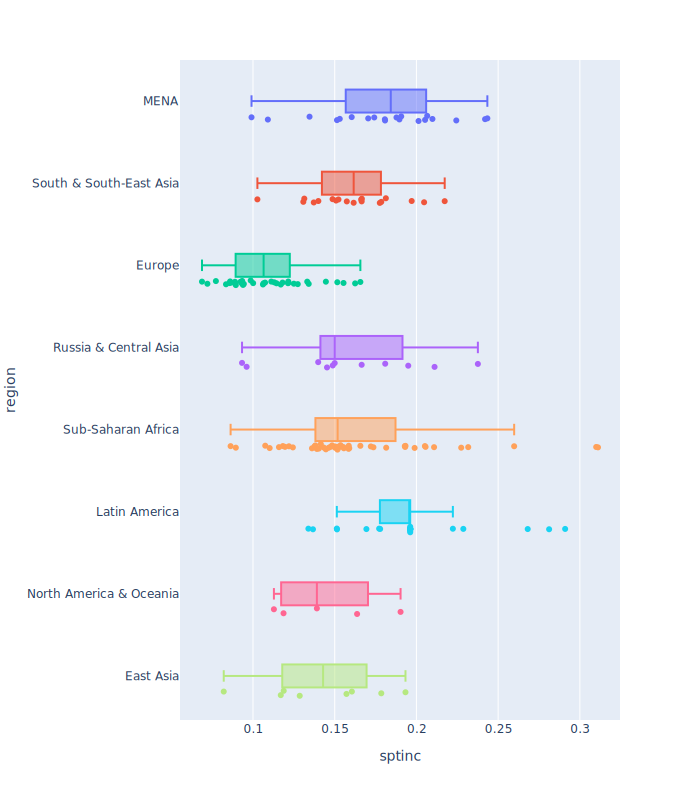

In [14]:
fig = px.box(
    df,
    y='region',
    x='sptinc',
    color='region',
    points='all',
    hover_name='country',
    orientation='h'
)
fig.update_layout(
    height=800,
    showlegend=False,
    boxgap=0.6,
)
fig.show('svg')

First remarks:

* The original plot shows a World Average dot, but this does not corresponds to my dataframe and neither corresponds to the one reported by the WID.

In [15]:
region_median = df.groupby('region').median('sptinc')
region_median = region_median.rename(columns={'sptinc':'median'})

In [16]:
df = df.merge(region_median, how='left', on='region')

In [17]:
df = df.sort_values('median', ascending=False)

In [18]:
df

,country_id,region,country,sptinc,median
116,NI,Latin America,Nicaragua,0.1962,0.1962
130,PY,Latin America,Paraguay,0.1962,0.1962
31,CL,Latin America,Chile,0.2287,0.1962
24,BZ,Latin America,Belize,0.1962,0.1962
67,HT,Latin America,Haiti,0.1962,0.1962
...,...,...,...,...,...
139,SE,Europe,Sweden,0.1170,0.1065
38,CY,Europe,Cyprus,0.0890,0.1065
141,SI,Europe,Slovenia,0.0835,0.1065
142,SK,Europe,Slovakia,0.0721,0.1065


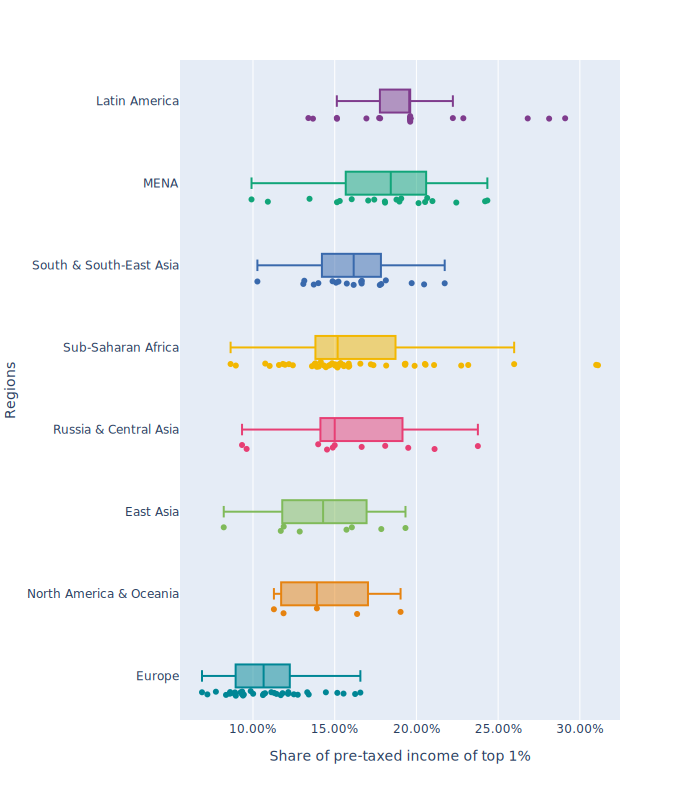

In [19]:
n_regions = df['region'].unique().size
fig = px.box(
    df,
    y='region',
    x='sptinc',
    color='region',
    points='all',
    hover_name='country',
    orientation='h',
    labels={'region':'Regions', 'sptinc': 'Share of pre-taxed income of top 1%'},
    color_discrete_sequence=px.colors.qualitative.Bold[:n_regions]
)
fig.update_layout(
    height=800,
    showlegend=False,
    boxgap=0.6,
)
fig.layout.xaxis.tickformat = ',.2%'
fig.show('svg')